# Partitioning

Several methods are available to partition 2D wave spectra

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

from wavespectra import read_ww3

datadir = Path("../data")

dset = read_ww3(datadir / "ww3file.nc")
dset

<xarray.Dataset> Size: 44kB
Dimensions:  (time: 9, site: 2, freq: 25, dir: 24)
Coordinates:
  * freq     (freq) float32 100B 0.04118 0.0453 0.04983 ... 0.3352 0.3687 0.4056
  * site     (site) int32 8B 1 2
  * time     (time) datetime64[ns] 72B 2014-12-01 ... 2014-12-05
  * dir      (dir) float32 96B 270.0 255.0 240.0 225.0 ... 315.0 300.0 285.0
Data variables:
    dpt      (time, site) float32 72B dask.array<chunksize=(9, 2), meta=np.ndarray>
    efth     (time, site, freq, dir) float32 43kB dask.array<chunksize=(9, 2, 25, 24), meta=np.ndarray>
    lat      (site) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    lon      (site) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    wspd     (time, site) float32 72B dask.array<chunksize=(9, 2), meta=np.ndarray>
    wdir     (time, site) float32 72B dask.array<chunksize=(9, 2), meta=np.ndarray>

## Frequency split

In [2]:
fcut = 1 / 8

sea = dset.spec.split(fmin=fcut)
swell = dset.spec.split(fmax=fcut)

print("Full spectrum\n", dset.freq.values)
print("Sea\n", sea.freq.values)
print("Swell\n", swell.freq.values)

Full spectrum
 [0.04118    0.045298   0.0498278  0.05481058 0.06029164 0.06632081
 0.07295289 0.08024818 0.08827299 0.09710029 0.10681032 0.11749136
 0.1292405  0.14216454 0.15638101 0.17201911 0.18922101 0.20814312
 0.22895744 0.25185317 0.27703848 0.30474234 0.3352166  0.36873826
 0.40561208]
Sea
 [0.125      0.1292405  0.14216454 0.15638101 0.17201911 0.18922101
 0.20814312 0.22895744 0.25185317 0.27703848 0.30474234 0.33521661
 0.36873826 0.40561208]
Swell
 [0.04118    0.045298   0.0498278  0.05481058 0.06029164 0.06632081
 0.07295289 0.08024818 0.08827299 0.09710029 0.10681032 0.11749136
 0.125     ]


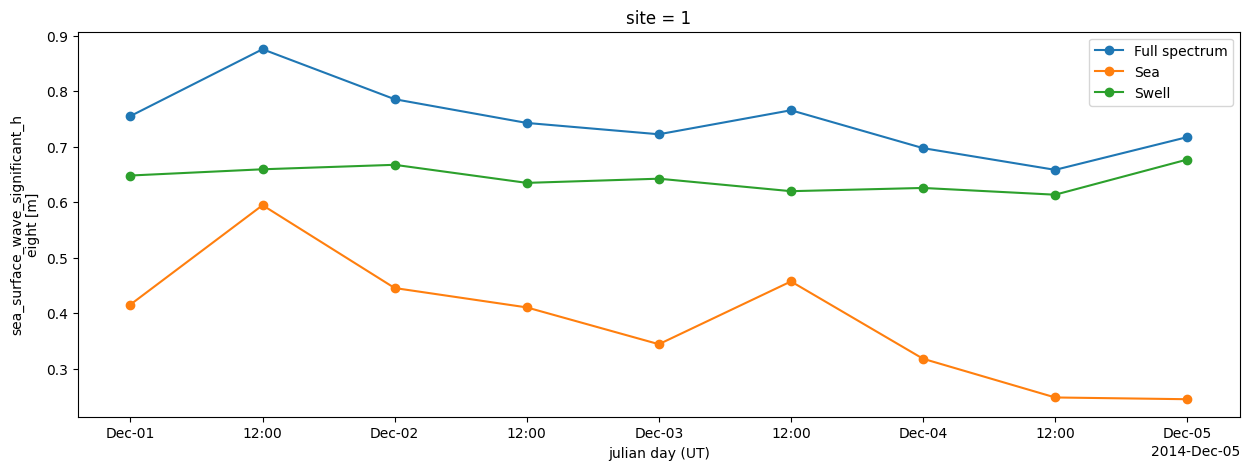

In [3]:
fig = plt.figure(figsize=(15, 5))

dset.spec.hs().isel(site=0).plot(label='Full spectrum', marker='o');
sea.spec.hs().isel(site=0).plot(label='Sea', marker='o');
swell.spec.hs().isel(site=0).plot(label='Swell', marker='o');
plt.legend();

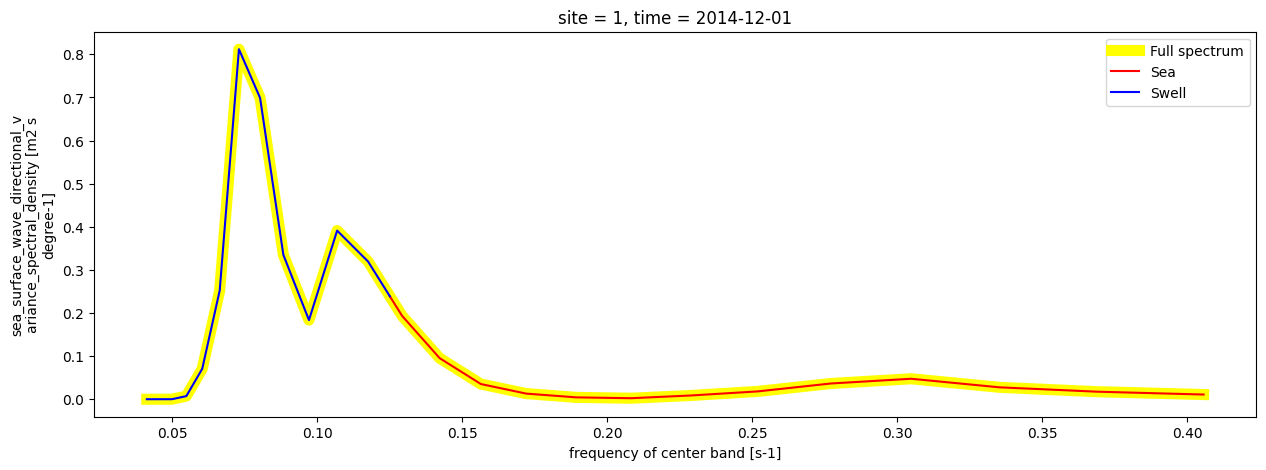

In [4]:
fig = plt.figure(figsize=(15, 5))

dset.isel(site=0, time=0).spec.oned().plot(label="Full spectrum", linewidth=8, color="yellow");
sea.isel(site=0, time=0).spec.oned().plot(label="Sea", color="red");
swell.isel(site=0, time=0).spec.oned().plot(label="Swell", color="blue");
plt.legend();

## Watershed

The watershed method is modified from WW3 Fortran src code for speed. The method requires water depth, wind speed and direction as main inputs. The output is a Dataset with an extra `par` dimension where the first index corresponds to the wind-forced partition and the remaining indices are the different swells available sorted by Hs.

In [5]:
dset.spec.partition?

Type:        Partition
String form: <wavespectra.partition.partition.Partition object at 0x705ee474fe50>
File:        /source/wavespectra/wavespectra/partition/partition.py
Docstring:  
Spectra partition methods.

Methods:
    - ptm1: In PTM1, topographic partitions for which the percentage of wind-sea energy exceeds a
      defined fraction are aggregated and assigned to the wind-sea component (e.g., the first
      partition). The remaining partitions are assigned as swell components in order of
      decreasing wave height.
    - ptm2: PTM2 works in a similar way to PTM1 by identifying a primary wind sea (assigned as
      partition 0) and one or more swell components. In this method however all the swell
      partitions are checked for the influence of wind-sea with energy within spectral bins
      within the wind-sea range (as defined by a wave age criterion) removed and combined
      into a secondary wind-sea partition (assigned as partition 1). The remaining swell
      parti

In [6]:
dspart = dset.spec.partition.ptm1(dset.wspd, dset.wdir, dset.dpt)
dspart

<xarray.DataArray 'efth' (part: 4, time: 9, site: 2, freq: 25, dir: 24)> Size: 173kB
dask.array<transpose, shape=(4, 9, 2, 25, 24), dtype=float32, chunksize=(4, 9, 2, 25, 24), chunktype=numpy.ndarray>
Coordinates:
  * freq     (freq) float32 100B 0.04118 0.0453 0.04983 ... 0.3352 0.3687 0.4056
  * site     (site) int32 8B 1 2
  * time     (time) datetime64[ns] 72B 2014-12-01 ... 2014-12-05
  * dir      (dir) float32 96B 270.0 255.0 240.0 225.0 ... 315.0 300.0 285.0
  * part     (part) int64 32B 0 1 2 3
Attributes:
    standard_name:  sea_surface_wave_directional_variance_spectral_density
    units:          m2 s degree-1
    part0:          wind sea
    part1-n:        swells in descending order of hs

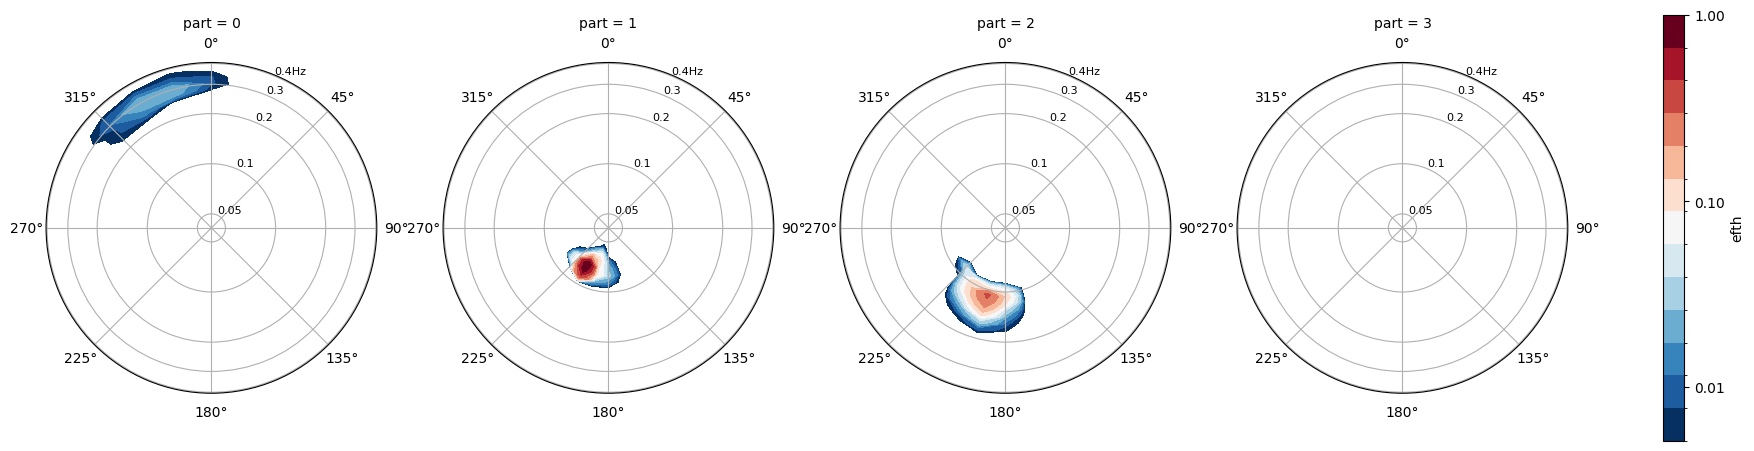

In [7]:
dspart.isel(time=0, site=0).spec.plot(col="part", figsize=(20, 5));

Spectral statistics can be calculated for individual partitions:

In [8]:
pstats = dspart.spec.stats(["hs", "dpm"])
pstats

<xarray.Dataset> Size: 688B
Dimensions:  (site: 2, time: 9, part: 4)
Coordinates:
  * site     (site) int32 8B 1 2
  * time     (time) datetime64[ns] 72B 2014-12-01 ... 2014-12-05
  * part     (part) int64 32B 0 1 2 3
Data variables:
    hs       (part, time, site) float32 288B dask.array<chunksize=(4, 9, 2), meta=np.ndarray>
    dpm      (part, time, site) float32 288B dask.array<chunksize=(4, 9, 2), meta=np.ndarray>
Attributes:
    standard_name:  sea_surface_wave_significant_height
    units:          m

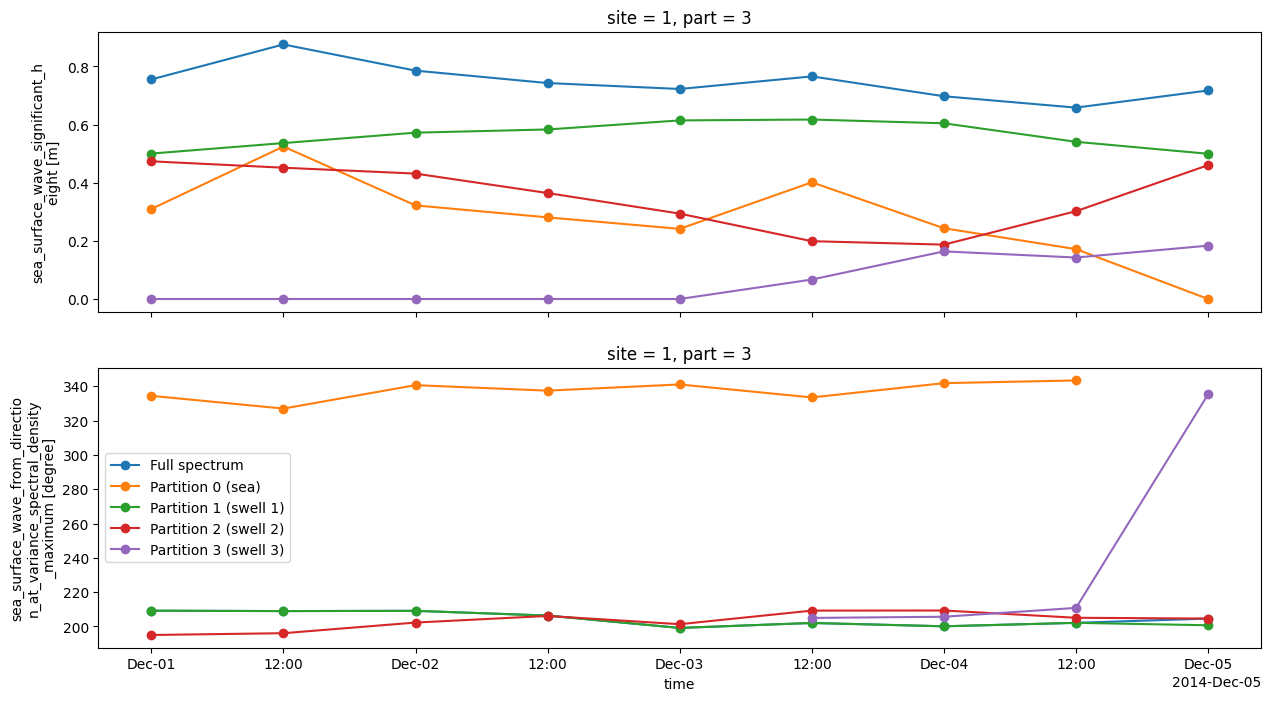

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

dset.spec.hs().isel(site=0).plot(ax=ax1, label='Full spectrum', marker='o');
pstats.hs.isel(part=0, site=0).plot(ax=ax1, label='Partition 0 (sea)', marker='o');
pstats.hs.isel(part=1, site=0).plot(ax=ax1, label='Partition 1 (swell 1)', marker='o');
pstats.hs.isel(part=2, site=0).plot(ax=ax1, label='Partition 2 (swell 2)', marker='o');
pstats.hs.isel(part=3, site=0).plot(ax=ax1, label='Partition 3 (swell 3)', marker='o');
ax1.set_xlabel("")
ax1.set_xticklabels("")

dset.spec.dpm().isel(site=0).plot(ax=ax2, label='Full spectrum', marker='o');
pstats.dpm.isel(part=0, site=0).plot(ax=ax2, label='Partition 0 (sea)', marker='o');
pstats.dpm.isel(part=1, site=0).plot(ax=ax2, label='Partition 1 (swell 1)', marker='o');
pstats.dpm.isel(part=2, site=0).plot(ax=ax2, label='Partition 2 (swell 2)', marker='o');
pstats.dpm.isel(part=3, site=0).plot(ax=ax2, label='Partition 3 (swell 3)', marker='o');
plt.legend();